In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST("./MNIST_data/", download=True, train=True, transform=transform) #carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # cria um buffer para pegar os dados por partes

valset = datasets.MNIST("./MNIST_data/", download=True, train=False, transform=transform) #carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=True)

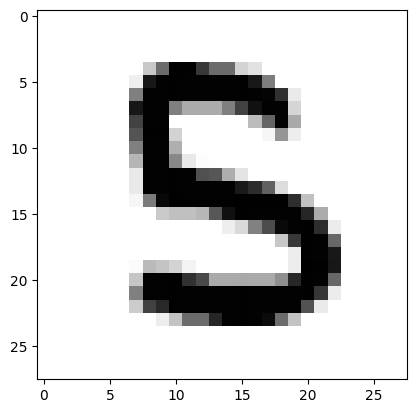

In [3]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.__next__()
plt.imshow(imagens[0].numpy().squeeze(),cmap="gray_r")

In [4]:
print(imagens[0].shape) #para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #para verificar as dimensões do tensor de cada etiquetas

torch.Size([1, 28, 28])
torch.Size([])


In [5]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28,128) #cadama de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128,64) #cadama interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64,10) #camada interna 2, 64 neurônios que se ligam a 10
        #para cada camada  de saida não é necessário definir nada pois só precisamos pegar o output da camada interna 2
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x,dim=1)

In [ ]:
def treino(modelo,treinloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a política de atualização dos pesos e da bias
    inicio = time() #timer para saber quanto tempo levou o treino
    
    criterio = nn.NLLLoss() #definindo o criterio para calcular a perda
    EPOCHS = 10 #numero de epocas que o algoritmo rodará
    modelo.train() #ativando o modo de treinamento do modelo
    
    for epoch in range(0,EPOCHS,1):
        perda_acumulada = 0 #inicializando a perda acumulada da epoca em questão
        
        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0],-1) #convertendo as imagens para vetores de 28 * 28 casas
            otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) #calculando a perda da epoca em questão
            
            perda_instantanea.backward() #back propagation a partir da perda
            
            otimizador.step() #atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() #atualizando a perda acumulada
            

In [6]:
def validacao(modelo, valloader,device):
    conta_corretas, conta_todas = 0,0
    for imagens, etiquetas in  valloader:
        for i in range(0,len(etiquetas),1):
            img = imagens[i].view(1,784)
            #desativar autograd para acelerar a validação. Grafos computacionais dinâmicos tem um alto custo de processamento
            with torch.no_grad():
                logps = modelo(img.to(device))
                
            ps = torch.exp(logps) # converte output para escala normal (lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) #converte o tensor em número, no caso, o número que o modelo previu
            etiqueta_certa = etiquetas.numpy()[i]
            
            if(etiqueta_certa == etiqueta_pred): #compara da previsão com o valor correto
                conta_corretas +=1
                
            conta_todas +=1
                
    print("todas as imagens testadas = ", conta_todas)
    print("Precisão do modelo = ",conta_corretas*100/conta_todas)

In [7]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)